In [1]:
!pip install catboost
!pip install lightgbm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, make_scorer
import lightgbm as lgb

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Подготовка данных

Загрузим жанные:

In [2]:
try:
    
    df = pd.read_csv('autos.csv', sep=',')
      
except:
    
    df = pd.read_csv('/datasets/autos.csv', sep=',')

pd.options.display.max_columns = None


Напишем функцию для открытия и просмотра данных:

In [3]:
def intro(x):
    """
    принимает: x - датасет
       выдаёт: общую информацию, первые пять строк и последние пять строк таблицы, 
               описание данных и количество дубликатов.
             
     описание: Функция дает первичную информацию о данных в датасете.
    """
    print('\033[1m' + 'Общая информация:')
    print ('\033[0m')
    display(x.info())
    print('\033[1m' + 'Первые пять строк:')
    print ('\033[0m')
    display(x.head())
    print('\033[1m' + 'Последние пять строк:')
    print ('\033[0m')
    display(x.tail())
    print('\033[1m' + 'Описание данных:')
    print ('\033[0m')
    display(x.describe()) 
    print('\033[1m' + 'Пропуски в данных:')
    print ('\033[0m')
    display(x.isna().sum()) 
    print('\033[1m' + 'Дубликаты:')
    print ('\033[0m')
    display(x.duplicated().sum())  


Применим функцию к данным:

In [4]:
intro(df)

Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


None

Первые пять строк:



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Последние пять строк:



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


Описание данных:



,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Пропуски в данных:



DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Дубликаты:



4

Описание данных:

Признаки

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

NotRepaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

Целевой признак

Price — цена (евро)


Выводы:

В данных есть пропуски в столбцах:VehicleType,Gearbox,Model,FuelType,NotRepaired.
Так же в данных есть полные дубликаты.

Нужно:

Заполнить пропуски 
Model - удалим пропуски их не так много, и не понятно как доставерно их восстановить.
VehicleType,Gearbox,FuelType - заполним наиболее популярными значениями на основе моделей.
NotRepaired - заполним на no, так как логично предположить что пропуск значит не была в ремонте.

Заполним пропуски:

In [5]:
df = df.dropna(subset=['Model'])
df['VehicleType'] = df['VehicleType'].fillna(df.groupby(by = 'Model')['VehicleType'].transform(lambda x:x.mode()[0]))
df['Gearbox'] = df['Gearbox'].fillna(df.groupby(by = 'Model')['Gearbox'].transform(lambda x:x.mode()[0]))
df['FuelType'] = df['FuelType'].fillna(df.groupby(by = 'Model')['FuelType'].transform(lambda x:x.mode()[0]))
df['NotRepaired'] = df['FuelType'].fillna('no')

Проверим:

In [6]:
df.isna().sum()   

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Уберем дубликаты:

In [7]:
df = df.drop_duplicates()

Проверим :

In [8]:
df.duplicated().sum()

0

Проверим распределение данных, уберём выбросы:

In [9]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,334659.000000,334659.000000,334659.000000,334659.000000,334659.000000,334659.0,334659.000000
mean,4504.346864,2003.924012,111.372564,128562.805722,5.806065,0.0,50671.283270
std,4531.440082,69.377736,185.157659,37205.693708,3.689158,0.0,25754.553187
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1150.000000,1999.000000,70.000000,125000.000000,3.000000,0.0,30419.000000
50%,2800.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49525.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71229.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Посмотрим на цену:

Text(0.5, 1.0, 'Распределение объявлений по цене')

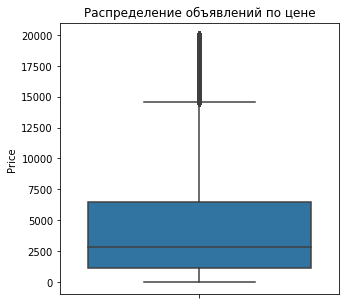

In [10]:
plt.figure(figsize = (5, 5))
sns.boxplot(y = 'Price', data=df)
plt.title('Распределение объявлений по цене')

Цена не может быть нулевой,это ошибка и как видно все что выше 15000 тоже можно убрать:

In [11]:
df = df.query('Price!= 0 and Price < 15000')

Проверим года:

Text(0.5, 1.0, 'Распределение объявлений по году')

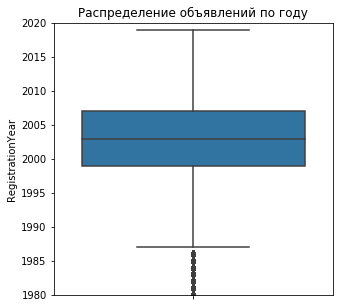

In [12]:
plt.figure(figsize = (5, 5))
sns.boxplot(y = 'RegistrationYear', data=df)
plt.ylim(1980,2020)
plt.title('Распределение объявлений по году')

Логично убираем лишние года всё что ниже 1986 и выше 2019:

In [13]:
df = df.query('RegistrationYear > 1987 and RegistrationYear  < 2020')

Посмотрим на мощность:

Text(0.5, 1.0, 'Распределение объявлений по мощности авто')

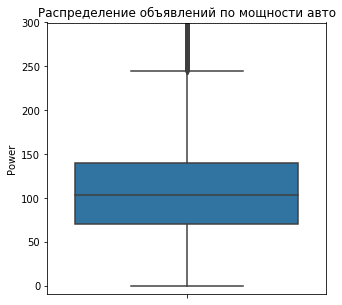

In [14]:
plt.figure(figsize = (5, 5))
sns.boxplot(y = 'Power', data=df)
plt.ylim(-10,300)
plt.title('Распределение объявлений по мощности авто')

Как видно обычно мощность серийных авто меньше 250 лс, а авто с 0 лс это ошибки

In [15]:
df = df.query('Power > 0 and Power  < 250')

Убираем лишние столбцы:
* Признаки NumberOfPictures, PostalCode не несут полезной информации, удалим их.
* Также DateCrawled, DateCreated,'LastSeen' - не несут информации об автомобиле.
* RegistrationMonth вряд ли влияет на цену автомобиля

In [16]:
df = df.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'RegistrationMonth', 'DateCreated','LastSeen'], axis=1)

Проверим:

In [17]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,gasoline
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,petrol
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,gasoline
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,petrol
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,petrol


Кодируем котегориальные признаки:

In [18]:
df_ohe = pd.get_dummies(df, drop_first=True)

Проверим:

In [19]:
df_ohe.head()

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_electric,NotRepaired_gasoline,NotRepaired_hybrid,NotRepaired_lpg,NotRepaired_other,NotRepaired_petrol
2,9800,2004,163,125000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

Разделим данные :

In [20]:
features = df_ohe.drop('Price', axis=1)
target = df_ohe['Price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=180495)

Проверим:

In [21]:
print(features_train.shape)
print(target_train.shape)
print()
print(features_test.shape)
print(target_test.shape)

(203026, 307)
(203026,)

(67676, 307)
(67676,)


Маштабируем признаки:

In [22]:
pd.options.mode.chained_assignment = None
numeric = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [23]:
features_train.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_electric,NotRepaired_gasoline,NotRepaired_hybrid,NotRepaired_lpg,NotRepaired_other,NotRepaired_petrol
247534,0.266588,-0.886069,-1.748283,0,0,0,1,0,0,0,1,0,0,0,0,0,

## Обучение моделей

Подбереём лучшие параметры для catboost с учетом метрики RMSE:

In [28]:
%%time
catboost = CatBoostRegressor(loss_function='RMSE')
parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(features_train, target_train),
            cv=3,
            verbose=True,
            plot=False)

0:	learn: 5018.8081279	test: 5025.0387762	best: 5025.0387762 (0)	total: 73.3ms	remaining: 1m 13s
1:	learn: 4612.6888572	test: 4618.7031716	best: 4618.7031716 (1)	total: 103ms	remaining: 51.3s
2:	learn: 4256.4733876	test: 4261.3813364	best: 4261.3813364 (2)	total: 127ms	remaining: 42.1s
3:	learn: 3942.9600734	test: 3948.2707842	best: 3948.2707842 (3)	total: 150ms	remaining: 37.2s
4:	learn: 3662.3146089	test: 3667.9275635	best: 3667.9275635 (4)	total: 173ms	remaining: 34.4s
5:	learn: 3412.8481596	test: 3418.8053899	best: 3418.8053899 (5)	total: 195ms	remaining: 32.3s
6:	learn: 3193.0338213	test: 3199.0515364	best: 3199.0515364 (6)	total: 217ms	remaining: 30.8s
7:	learn: 3004.2576591	test: 3011.4293765	best: 3011.4293765 (7)	total: 239ms	remaining: 29.7s
8:	learn: 2835.8097681	test: 2843.3275959	best: 2843.3275959 (8)	total: 262ms	remaining: 28.8s
9:	learn: 2687.5408369	test: 2695.5351082	best: 2695.5351082 (9)	total: 290ms	remaining: 28.7s
10:	learn: 2562.0814974	test: 2569.9637007	best:

Посмотрим на параметры:

In [29]:
catboost_grid["params"]

{'depth': 10, 'learning_rate': 0.30000000000000004}

Посмотрим на время обучения с извстными параметрами:

In [31]:
%%time
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(features_train, target_train)

0:	learn: 2885.5673503	total: 61.6ms	remaining: 1m 1s
100:	learn: 1316.4900638	total: 5.85s	remaining: 52.1s
200:	learn: 1256.4554124	total: 11.7s	remaining: 46.7s
300:	learn: 1223.0739970	total: 17.7s	remaining: 41.1s
400:	learn: 1196.3783641	total: 24s	remaining: 35.9s
500:	learn: 1175.3068450	total: 29.8s	remaining: 29.7s
600:	learn: 1158.9126529	total: 35.7s	remaining: 23.7s
700:	learn: 1144.6779856	total: 42.7s	remaining: 18.2s
800:	learn: 1131.3260418	total: 49.9s	remaining: 12.4s
900:	learn: 1120.6058953	total: 55.9s	remaining: 6.14s
999:	learn: 1111.2712683	total: 1m 1s	remaining: 0us
CPU times: user 3min 16s, sys: 5.7 s, total: 3min 22s
Wall time: 1min 3s


Обучим модель Случайного леса:

In [63]:
%%time
RF = RandomForestRegressor()
params =  {'n_estimators': [10, 50, 80, 100],
               'max_depth' : [5, 10 , 15]}
grid_search_RF = GridSearchCV(estimator = RF, param_grid = params,cv=3)
grid_search_RF.fit(features_train,target_train)

CPU times: user 1h 12min 22s, sys: 8.64 s, total: 1h 12min 31s
Wall time: 1h 12min 32s


GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [10, 50, 80, 100]})

Посмотрим лучшие параметры:

In [73]:
param_RF = grid_search_RF.best_params_
param_RF 

{'max_depth': 15, 'n_estimators': 100}

Обучим LightGBM:

In [91]:
%%time
lgb_train = lgb.Dataset(features_train,target_train)
lgb_test = lgb.Dataset(features_test,target_test, reference=lgb_train)
parameters_light = {'metric': 'l2', 'max_depth':10,"random_state": 42,"learning_rate":0.1}
LG = lgb.train(parameters_light,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train, lgb_test],
                verbose_eval=100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 845
[LightGBM] [Info] Number of data points in the train set: 203026, number of used features: 283
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 4104.917341
[100]	training's l2: 1.97241e+06	valid_1's l2: 2.03554e+06
[200]	training's l2: 1.84377e+06	valid_1's l2: 1.93472e+06
[300]	training's l2: 1.76769e+06	valid_1's l2: 1.88245e+06
[400]	training's l2:

## Анализ моделей

Проверим время предсказаний моделей:

In [85]:
%%time
print("CatBoost:",mean_squared_error(target_test,final_cat.predict(features_test),squared=False))

CatBoost: 1292.3483904357824
CPU times: user 937 ms, sys: 164 ms, total: 1.1 s
Wall time: 1.6 s


In [94]:
%%time
print("RandomForest:",mean_squared_error(target_test,grid_search_RF.best_estimator_.predict(features_test),
                                         squared=False))

RandomForest: 1397.1004568362723
CPU times: user 1.95 s, sys: 52.6 ms, total: 2 s
Wall time: 2 s


In [93]:
%%time
print("LightGBM:",mean_squared_error(target_test,LG.predict(features_test),squared=False))

LightGBM: 1319.4408490798
CPU times: user 8.37 s, sys: 73.8 ms, total: 8.45 s
Wall time: 2.39 s


## Выводы

Как видно из пунктов Выше лучшей результаты дал CatBoost так как он дал лучшее качество модели, и скорость выше чем 
у других моделей.